<a href="https://colab.research.google.com/github/oliverfoster27/Practical-Machine-Learning/blob/master/Week%208/Homework_Week_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deploy Keras Model to the Cloud
1. Download data
2. Hot Encode Categorical Columns
3. Develop Model (use: ```RMSprop(lr=, rho=, epsilon=, decay=)```)
3. Create Storage Bucket (should already exist)
4. Authenticate on Google Cloud Platform
5. Deploy your model using the ```gcloud``` tool

### Download Data

In [1]:
!wget https://storage.googleapis.com/nicksdemobucket/bank.csv

--2019-05-03 12:07:16--  https://storage.googleapis.com/nicksdemobucket/bank.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4610348 (4.4M) [application/octet-stream]
Saving to: ‘bank.csv’

bank.csv            100%[===================>]   4.40M  --.-KB/s    in 0.08s   

2019-05-03 12:07:21 (57.1 MB/s) - ‘bank.csv’ saved [4610348/4610348]



In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('bank.csv', sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Hot Encode Categorical Columns

In [4]:
df.loc[df['y'] == 'no', 'y'] = 0
df.loc[df['y'] == 'yes', 'y'] = 1
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [5]:
# Get all categorical columns
categorical = df.select_dtypes(include='object').columns
print(categorical)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')


In [6]:
# Hot encode all categorical columns
for i in categorical:
  new_cols = pd.get_dummies(df[i], prefix=i)
  df = df.drop(i, axis=1)
  df = df.join(new_cols)
  
df.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

train, test = train_test_split(df, test_size=0.1)

X_train = min_max_scaler.fit_transform(train.drop(['y'], axis=1))
y_train = train[['y']].values

X_test = min_max_scaler.fit_transform(test.drop(['y'], axis=1))
y_test = test[['y']].values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


((40689, 51), (40689, 1), (4522, 51), (4522, 1))

### Develop Model
* Use ```RMSprop(lr=, rho=, epsilon=, decay=)```
* Plot accuracy and loss over time

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.train import RMSPropOptimizer
from tensorflow import keras
import tensorflow as tf

In [59]:
model = Sequential()

model.add(Dense(100, activation='relu', input_shape=(51,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = RMSPropOptimizer(learning_rate=10e-6, epsilon=1e-10, decay=0.8)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['acc'])

h = model.fit(X_train, y_train, epochs=150, validation_split=0.2)

Train on 32551 samples, validate on 8138 samples
Epoch 1/150
32551/32551 [==============================] - 6s 179us/sample - loss: 0.9205 - acc: 0.4899 - val_loss: 0.8027 - val_acc: 0.5240
Epoch 2/150
32551/32551 [==============================] - 6s 178us/sample - loss: 0.8103 - acc: 0.5382 - val_loss: 0.7173 - val_acc: 0.5823
Epoch 3/150
32551/32551 [==============================] - 6s 170us/sample - loss: 0.7464 - acc: 0.5838 - val_loss: 0.6583 - val_acc: 0.6374
Epoch 4/150
32551/32551 [==============================] - 5s 155us/sample - loss: 0.6948 - acc: 0.6168 - val_loss: 0.6138 - val_acc: 0.6822
Epoch 5/150
32551/32551 [==============================] - 5s 153us/sample - loss: 0.6533 - acc: 0.6499 - val_loss: 0.5744 - val_acc: 0.7293
Epoch 6/150
32551/32551 [==============================] - 5s 154us/sample - loss: 0.6153 - acc: 0.6778 - val_loss: 0.5383 - val_acc: 0.7793
Epoch 7/150
32551/32551 [==============================] - 5s 153us/sample - loss: 0.5869 - acc: 0.7019 -

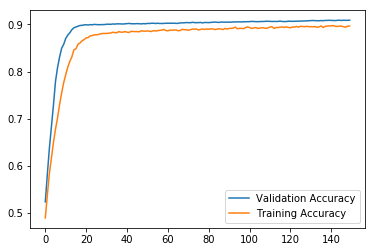

In [60]:
plt.plot(h.history['val_acc'], label='Validation Accuracy')
plt.plot(h.history['acc'], label='Training Accuracy')
plt.legend()

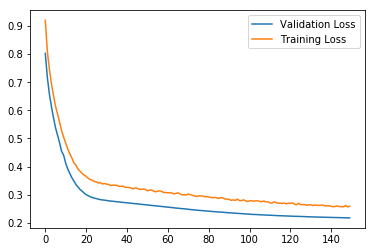

In [61]:
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.plot(h.history['loss'], label='Training Loss')
plt.legend()

### Create Storage

In [62]:
PROJECT_ID = "lofty-reserve-238701" #@param {type:"string"}

# This must absolutely be a GLOBALLY UNIQUE name
BUCKET_NAME = "oliver-ml-demo-bucket123" #@param {type:"string"}
REGION = "us-central1" #@param {type:"string"}

! gcloud config set project $PROJECT_ID
! echo $PROJECT_ID

Updated property [core/project].
lofty-reserve-238701


### Authenticate on Google Cloud Platform
* Click on link and enter secret key

In [0]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

In [63]:
# Create Bucket
!gsutil mb -p $PROJECT_ID -l $REGION gs://$BUCKET_NAME
# Display what is in the bucket
print('Bucket Content:')
!gsutil ls -al gs://$BUCKET_NAME

Creating gs://oliver-ml-demo-bucket123/...
ServiceException: 409 Bucket oliver-ml-demo-bucket123 already exists.
Bucket Content:
                                 gs://oliver-ml-demo-bucket123/mcgilldemo/


In [64]:
JOB_DIR = 'gs://' + BUCKET_NAME + '/mcgilldemo'
print(JOB_DIR)

gs://oliver-ml-demo-bucket123/mcgilldemo


### Export Model to Google Cloud Storage

In [65]:
export_path = tf.contrib.saved_model.save_keras_model(model, JOB_DIR + '/keras_export')
print("Model exported to: ", export_path)

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tens

### Deploy Model from GCS

In [66]:
# Create model
MODEL_NAME = "mcgilldemo2"

! gcloud ml-engine models create $MODEL_NAME \
  --regions $REGION

Created ml engine model [projects/lofty-reserve-238701/models/mcgilldemo2].


In [67]:
# Deploy model
MODEL_VERSION = "v1"

# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = ! gsutil ls $JOB_DIR/keras_export/

# Pick the directory with the latest timestamp, in case you've trained
# multiple times
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS[-1]

# Create model version based on that SavedModel directory
! gcloud ml-engine versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

### Test your model with your test set

In [68]:
# Create file with features to send to model
with open('test.json', 'w') as f:
  for item in X_test[:10]:
    item = list(item)
    f.write("%s\n" % item)
! cat test.json

[0.18181818181818182, 0.03886471700537902, 0.6333333333333333, 0.03204524033930255, 0.08108108108108109, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[0.15584415584415584, 0.045088212076150616, 0.5333333333333333, 0.10650329877474081, 0.05405405405405406, 0.22857142857142856, 0.007272727272727273, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
[0.5064935064935066, 0.047364652751005126, 0.4, 0.027961043041156142, 0.13513513513513514, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [69]:
# Send file to model for prediction
! gcloud ml-engine predict \
  --model $MODEL_NAME \
  --version $MODEL_VERSION \
  --json-instances test.json

DENSE_77
[0.010838687419891357]
[0.9132669568061829]
[0.014997661113739014]
[0.0015125870704650879]
[0.005704969167709351]
[0.0021437108516693115]
[0.021108150482177734]
[0.10229122638702393]
[0.1725328266620636]
[0.35158687829971313]


In [70]:
y_test[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])